[View in Colaboratory](https://colab.research.google.com/github/vbipin/nlp/blob/master/pytorch_nmt_with_attn.ipynb)

In [369]:
### !pip3 install torch

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
import numpy as np

In [4]:
#This notebook is adapted from
##http://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

In [5]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
#for monitoring
from time import time
#for parsing the data filename
import re

In [6]:
#here we prepare data directly form the web link. It is useful in Colab notebooks
#to convert to script
#jupyter nbconvert --to script [YOUR_NOTEBOOK].ipynb

In [7]:
#we need the data from : http://www.manythings.org/anki/fra-eng.zip
import requests
import gzip
import io
import zipfile

#get the contents from the website
"""r = requests.get('http://www.manythings.org/anki/fra-eng.zip')"""

#this is one ugly code; But I need the text from a zip file in a url :(((
#https://stackoverflow.com/questions/37704836/how-do-i-read-a-csv-file-thats-gzipped-from-url-python
#https://codeyarns.com/2013/10/03/how-to-read-contents-of-zip-file-in-python/
#https://docs.python.org/2/library/zipfile.html
"""
with zipfile.ZipFile( io.BytesIO(r.content), mode='r' ) as zip_file :
  print (zip_file.namelist())
  lines = zip_file.read('fra.txt').strip().split(b'\n')
  lines = [ str(l, 'utf-8') for l in lines ]
  print(len(lines))
"""
;

''

In [8]:
from transformer import *
from encoder_decoder import *

In [9]:
from multi30k_data import *

In [387]:
##################################################################

torch.Size([100, 1, 20])


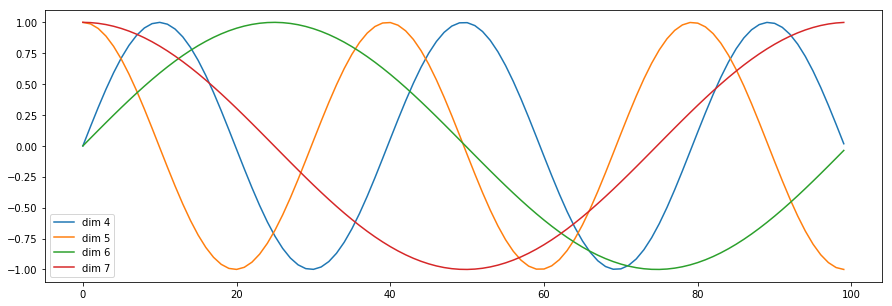

In [16]:
plt.figure(figsize=(15, 5))
#pe = PositionalEncoding(20, 0)
d_model = 20
n_position = 100
pe = nn.Embedding(n_position, d_model).from_pretrained( position_encoding_init(n_position, d_model ) )

a= torch.tensor( torch.arange(0,100).view(-1,1), dtype=torch.long )
y = pe( a )
print(y.shape)


plt.plot(np.arange(100), y[:, 0, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])


In [504]:
class EncodeDecodeRun :
    def __init__(self, encoder, decoder) :
        self.encoder = encoder
        self.decoder = decoder
        
        #these values will be filled by the encoders.
        self.g = None
        self.attn_values = None
        self.out = None
        
        if isinstance(encoder, EncoderSimple) :
            self.run_encoder = self.run_simple_encoder
        
        if isinstance(encoder, EncoderRNN) :
            self.run_encoder = self.run_rnn_encoder
            
        if isinstance(encoder, TransformerEncoder) :
            self.run_encoder = self.run_transformer_encoder
            
        if isinstance(decoder, DecoderRNN) :
            self.run_decoder = self.run_rnn_decoder
            
        if isinstance(decoder, AttnDecoderRNN) :
            self.run_decoder = self.run_attn_decoder 
    
    def run_simple_encoder(self, x ) :
        self.out = self.encoder(x)
        self.g = self.out.view(1,1,-1)
        self.attn_values = self.encoder.embedded
        
        
    def run_rnn_encoder(self, x ) :
        self.g = self.encoder.init_hidden()
        
        self.out, self.g = self.encoder(x, self.g )
        self.g.detach_()
        self.attn_values = self.out
        
        
    def run_transformer_encoder(self, x ) :
        #we create the position vectors from the input length
        #positions are 0-seq; shape same as x
        p = torch.tensor(range(x.shape[1]), device=device).view(1,-1)
        self.out = self.encoder( x, p )
        #out is of shape ( batch, seq, d_model )
        #self.g = torch.sum(self.out, dim=1, keepdim=True)
        self.g = self.out[:,0,:].view(1,1,-1) #XXX
        self.attn_values = None
        
        
    def run_rnn_decoder(self, yi ) :
            #for i in range(1) :
            scores, self.g = self.decoder( yi, self.g)
            #print(scores.shape)
            #print(next_word.shape)
            return scores
    
    def run_attn_decoder(self, yi ) :
        #self.attn_values is of shape (n,d)
        #we need it as (MAX_LENGTH, d) witht he first n filled
        max_length = self.decoder.max_length
        values_to_attend = torch.zeros(max_length, self.decoder.hidden_size, device=device)
        for i in range(self.attn_values.shape[0]) :
            values_to_attend[i] = self.attn_values[i][0]
                
        scores, self.g, _ = decoder( yi, self.g, values_to_attend )
        #print(scores.shape)
        #print(next_word.shape)
        return scores

def train(encdecrun, encoder_optimizer, decoder_optimizer, criterion, train_iter ) :
    start = time()
    
    loss_db = []
    for x, y in train_iter :
        x = x.to(device) #(seq, batch)
        y = y.to(device)
        #x = x.transpose(0,1).to(device) #becaue the data is in (seq,batch) we need in (batch,seq)
        #y = y.transpose(0,1).to(device)
        y_len = y.shape[0] #size of sequence
        
        loss = 0
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        
        #h = encoder.initHidden().to(device)
        #h.detach_()
        encdecrun.run_encoder( x )
    
        #g = torch.sum( encoder_outputs, dim=0 ).view(1,1,-1)
        
        y = y.detach()
        
        for i in range(y_len - 1) :
            scores = encdecrun.run_decoder( y[i, :] )
            loss += criterion(scores, y[i+1, :] )

        loss.backward()
        loss_db.append( float(loss) )
                
        encoder_optimizer.step()
        decoder_optimizer.step()
        
    end = time()
    print (end-start)
    return loss_db

In [528]:
# Note: This part is incredibly important. 
# Need to train with this setup of the model is very unstable.
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup**(-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

In [9]:
PAD = 0
UNK = 1
BOS = 2
EOS = 3

PAD_WORD = '<blank>'
UNK_WORD = '<unk>'
BOS_WORD = '<s>'
EOS_WORD = '</s>'

''' Data Loader class for training iteration '''
import random
import numpy as np
import torch
from torch.autograd import Variable
#import transformer.Constants as Constants

class DataLoader(object):
    ''' For data iteration '''

    def __init__(
            self, src_word2idx, tgt_word2idx,
            src_insts=None, tgt_insts=None,
            cuda=True, batch_size=64, shuffle=False, test=False):

        assert src_insts
        assert len(src_insts) >= batch_size

        if tgt_insts:
            assert len(src_insts) == len(tgt_insts)

        self.cuda = cuda
        self.test = test
        self._n_batch = int(np.ceil(len(src_insts) / batch_size))

        self._batch_size = batch_size

        self._src_insts = src_insts
        self._tgt_insts = tgt_insts

        src_idx2word = {idx:word for word, idx in src_word2idx.items()}
        tgt_idx2word = {idx:word for word, idx in tgt_word2idx.items()}

        self._src_word2idx = src_word2idx
        self._src_idx2word = src_idx2word

        self._tgt_word2idx = tgt_word2idx
        self._tgt_idx2word = tgt_idx2word

        self._iter_count = 0

        self._need_shuffle = shuffle

        if self._need_shuffle:
            self.shuffle()

    @property
    def n_insts(self):
        ''' Property for dataset size '''
        return len(self._src_insts)

    @property
    def src_vocab_size(self):
        ''' Property for vocab size '''
        return len(self._src_word2idx)

    @property
    def tgt_vocab_size(self):
        ''' Property for vocab size '''
        return len(self._tgt_word2idx)

    @property
    def src_word2idx(self):
        ''' Property for word dictionary '''
        return self._src_word2idx

    @property
    def tgt_word2idx(self):
        ''' Property for word dictionary '''
        return self._tgt_word2idx

    @property
    def src_idx2word(self):
        ''' Property for index dictionary '''
        return self._src_idx2word

    @property
    def tgt_idx2word(self):
        ''' Property for index dictionary '''
        return self._tgt_idx2word

    def shuffle(self):
        ''' Shuffle data for a brand new start '''
        if self._tgt_insts:
            paired_insts = list(zip(self._src_insts, self._tgt_insts))
            random.shuffle(paired_insts)
            self._src_insts, self._tgt_insts = zip(*paired_insts)
        else:
            random.shuffle(self._src_insts)


    def __iter__(self):
        return self

    def __next__(self):
        return self.next()

    def __len__(self):
        return self._n_batch

    def next(self):
        ''' Get the next batch '''

        def pad_to_longest(insts):
            ''' Pad the instance to the max seq length in batch '''

            max_len = max(len(inst) for inst in insts)

            inst_data = np.array([
                inst + [PAD] * (max_len - len(inst))
                for inst in insts])

            inst_position = np.array([
                [pos_i+1 if w_i != PAD else 0 for pos_i, w_i in enumerate(inst)]
                for inst in inst_data])

        
            inst_data_tensor = Variable(
                torch.LongTensor(inst_data), volatile=self.test)
            inst_position_tensor = Variable(
                torch.LongTensor(inst_position), volatile=self.test)

            if self.cuda:
                inst_data_tensor = inst_data_tensor.cuda()
                inst_position_tensor = inst_position_tensor.cuda()
            return inst_data_tensor, inst_position_tensor

        if self._iter_count < self._n_batch:
            batch_idx = self._iter_count
            self._iter_count += 1

            start_idx = batch_idx * self._batch_size
            end_idx = (batch_idx + 1) * self._batch_size

            src_insts = self._src_insts[start_idx:end_idx]
            src_data, src_pos = pad_to_longest(src_insts)

            if not self._tgt_insts:
                return src_data, src_pos
            else:
                tgt_insts = self._tgt_insts[start_idx:end_idx]
                tgt_data, tgt_pos = pad_to_longest(tgt_insts)
                return (src_data, src_pos), (tgt_data, tgt_pos)

        else:

            if self._need_shuffle:
                self.shuffle()

            self._iter_count = 0
            raise StopIteration()
 




In [10]:
data_file = 'multi30k.atok.low.pt'
data = torch.load(data_file)

max_token_seq_len = data['settings'].max_token_seq_len
batch_size = 64

training_data = DataLoader(
        data['dict']['src'],
        data['dict']['tgt'],
        src_insts=data['train']['src'],
        tgt_insts=data['train']['tgt'],
        batch_size=batch_size,
        cuda=True)

In [17]:
n_src_vocab = training_data.src_vocab_size
n_tgt_vocab = training_data.tgt_vocab_size
print(n_src_vocab, n_tgt_vocab)

2909 3149


In [11]:
def get_attn_padding_mask(seq_q, seq_k):
    ''' Indicate the padding-related part to mask '''
    assert seq_q.dim() == 2 and seq_k.dim() == 2
    mb_size, len_q = seq_q.size()
    mb_size, len_k = seq_k.size()
    pad_attn_mask = seq_k.data.eq(PAD).unsqueeze(1)   # bx1xsk
    pad_attn_mask = pad_attn_mask.expand(mb_size, len_q, len_k) # bxsqxsk
    return pad_attn_mask

def get_attn_subsequent_mask(seq):
    ''' Get an attention mask to avoid using the subsequent info.'''
    assert seq.dim() == 2
    attn_shape = (seq.size(0), seq.size(1), seq.size(1))
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    subsequent_mask = torch.from_numpy(subsequent_mask)
    if seq.is_cuda:
        subsequent_mask = subsequent_mask.cuda()
    return subsequent_mask

In [812]:
from transformer import *

In [922]:
for i,v in enumerate(training_data) :
    s,t = v
    if i > 200 :
        break

In [923]:
s[0].shape, t[0].shape

(torch.Size([64, 28]), torch.Size([64, 21]))

In [924]:
#a = get_attn_padding_mask(t[0],t[0])
a = get_padding_mask(t[0],t[0].shape[1])
a.shape

torch.Size([64, 21, 21])

In [925]:
a[0]

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [926]:
b = get_attn_subsequent_mask(t[0])
#b = get_subsequent_mask(t[0])
b.shape

torch.Size([64, 21, 21])

In [927]:
b[0]

tensor([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [928]:
torch.gt(a + b, 0)[-1]

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [931]:
c = get_attn_padding_mask(t[0], t[0])
c.shape

torch.Size([64, 21, 21])

In [932]:
c[0]

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [933]:
a[0]

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [934]:
d = get_attn_subsequent_mask(t[0])
#b = get_subsequent_mask(t[0])
d.shape, b.shape

(torch.Size([64, 21, 21]), torch.Size([64, 21, 21]))

In [935]:
d[0]

tensor([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [936]:
b[0]

tensor([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [937]:
from transformer import *

In [822]:
i = Transformer(n_src_vocab, n_trg_vocab, n_max_seq=50).to(device)

In [823]:
u = i(s[0], s[1], t[0], t[1])

In [824]:
u.shape

torch.Size([1728, 10839])

In [720]:
i.decoder.debug3.shape

torch.Size([1, 11, 512])

In [18]:
train_iter = multi30k_data.val_batch(device=device)

In [33]:
def get_performance(crit, pred, gold, smoothing=False, num_class=None):
    ''' Apply label smoothing if needed '''

    # TODO: Add smoothing
    if smoothing:
        assert bool(num_class)
        eps = 0.1
        gold = gold * (1 - eps) + (1 - gold) * eps / num_class
        raise NotImplementedError

    loss = crit(pred, gold.contiguous().view(-1))

    pred = pred.max(1)[1]

    gold = gold.contiguous().view(-1)
    n_correct = pred.data.eq(gold.data)
    n_correct = n_correct.masked_select(gold.ne(PAD).data).sum()

    return loss, n_correct

def train_epoch(model, training_data, crit, optimizer):
    ''' Epoch operation in training phase'''

    model.train()

    total_loss = 0.0
    n_total_words = 0.0
    n_total_correct = 0.0
    count  = 0
    
    for batch in training_data:

        # prepare data
        src, tgt = batch
        gold = tgt[0][:, 1:]

        # forward
        optimizer.zero_grad()
        pred = model(src[0],src[1], tgt[0], tgt[1])
        
        #print(gold.shape, pred.shape)
        #break
        # backward
        loss, n_correct = get_performance(crit, pred, gold)
        loss.backward()

        # update parameters
        optimizer.step()
        #optimizer.update_learning_rate()

        # note keeping
        #n_words = gold.data.ne(PAD).sum()
        n_words = gold.data.ne(PAD).sum()
        n_total_words += n_words #.item()
        n_total_correct += n_correct
        total_loss += float(loss)
        count += 1 
        if (count % 50) == 0 :
            print(float(loss))
        #print(float(loss))
    return total_loss, n_total_words, n_total_correct, n_total_words
    #return total_loss/n_total_words, n_total_correct/n_total_words

In [13]:
def get_criterion(vocab_size):
        ''' With PAD token zero weight '''
        weight = torch.ones(vocab_size)
        weight[PAD] = 0
        return nn.CrossEntropyLoss(weight, size_average=False).cuda()

crit = get_criterion(training_data.tgt_vocab_size)

crit = nn.CrossEntropyLoss()

/home/local/SPREADTRUM/bipin.vijayasenan/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [19]:
from transformer import *
model = Transformer(n_src_vocab, n_tgt_vocab, n_max_seq=50).to(device).cuda()
optimizer = optim.Adam(
            model.parameters(),
            betas=(0.9, 0.98), eps=1e-09)

In [23]:
import time
s = time.time()
e = time.time()
e-s

3.62396240234375e-05

In [34]:
train_iter = gen_train_iter(training_data, 400)
s = time.time()
i,j,k,l= train_epoch(model, train_iter, crit, optimizer)
e = time.time()
print(e-s, i, j, k, l)

torch.Size([64, 26]) torch.Size([1664, 3149])
0.11042475700378418 0.0 0.0 0.0 0.0


In [32]:
i/j.item(), k.item()/l.item()

(0.003937904306196198, 0.0)

26.0

In [847]:
vars(model.decoder.layers[0].multi_head_attn.multi_attn[1].attn_scores)

{}

In [848]:
model.decoder.layers[0].multi_head_attn.multi_attn[1].attn_scores.shape

torch.Size([64, 25, 25])

In [944]:
model.decoder.layer_list[0].multi_head_attn.multi_attn[1].attn_scores[0]

tensor([[0.0669, 0.0661, 0.0669, 0.0667, 0.0666, 0.0666, 0.0666, 0.0667, 0.0662,
         0.0666, 0.0668, 0.0669, 0.0667, 0.0668, 0.0670, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0666, 0.0664, 0.0667, 0.0666, 0.0667, 0.0666, 0.0666, 0.0667, 0.0665,
         0.0667, 0.0668, 0.0667, 0.0667, 0.0668, 0.0669, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0666, 0.0664, 0.0668, 0.0666, 0.0666, 0.0666, 0.0666, 0.0666, 0.0665,
         0.0667, 0.0667, 0.0668, 0.0668, 0.0668, 0.0671, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0665, 0.0665, 0.0667, 0.0666, 0.0667, 0.0665, 0.0666, 0.0667, 0.0666,
         0.0667, 0.0668, 0.0668, 0.0667, 0.0667, 0.0669, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

In [21]:
import itertools
def gen_train_iter(training_data, n_data=1000) :
    training_data._iter_count = 0 #reset from beginning
    for v in itertools.islice(training_data,0,n_data) :
        yield v

In [48]:
x, y = next(train_iter)
print(x.shape, y.shape)
#shape in (seq, batch)
#we make the shapes as (batch. seq)
#x = x.transpose(0,1).to(device)
#y = y.transpose(0,1).to(device)
x = x.to(device)
y = y.to(device)

#positions are 0-seq; shape same as x
p = torch.tensor(range(x.shape[1]), device=device).view(1,-1)

print(x.shape, y.shape, p.shape)

torch.Size([7, 1]) torch.Size([9, 1])
torch.Size([7, 1]) torch.Size([9, 1]) torch.Size([1, 1])


/home/local/SPREADTRUM/bipin.vijayasenan/anaconda3/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)


In [850]:
from transformer import *

In [158]:


hidden_size = 64
#encoder = EncoderRNN(len(multi30k_data.src_lang.vocab), hidden_size).to(device)
n_src_vocab = len(multi30k_data.src_lang.vocab)
n_trg_vocab = len(multi30k_data.trg_lang.vocab)

#encoder = EncoderSimple(n_src_vocab, hidden_size).to(device)
#encoder = EncoderRNN(n_src_vocab, hidden_size).to(device)
encoder = TransformerEncoder(n_src_vocab, d_model=hidden_size, n_head=6, n_max_seq=50, d_v=64, d_ffn=64 ).to(device)

decoder = DecoderRNN(hidden_size, n_trg_vocab).to(device)

#decoder = AttnDecoderRNN(hidden_size, len(multi30k_data.trg_lang.vocab), max_length=50  ).to(device)

#print(encoder)
#print(decoder)

In [159]:
learning_rate = 0.01
#encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
encoder_optimizer = optim.Adam( filter(lambda p: p.requires_grad, encoder.parameters()) , lr=learning_rate)

decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss().to(device)
#criterion = nn.CrossEntropyLoss().to(device)


In [115]:
a = encoder( x, p )

In [116]:
x.shape

torch.Size([14, 1])

In [117]:
print(encoder.debug2)

torch.Size([1, 14, 64])


In [118]:
a = encoder.layers.layer_list[0].attn_scores[0][0].clone().cpu()

AttributeError: 'Sequential' object has no attribute 'layer_list'

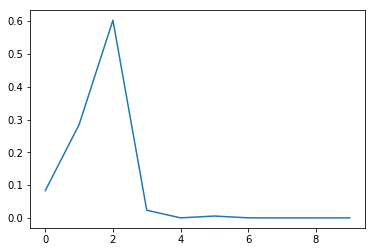

In [347]:
plt.plot(a[7].data.numpy())

In [167]:
torch.sum(a,dim=0).squeeze().shape

torch.Size([256])

In [119]:
encoder.debug, x.shape, y.shape

(torch.Size([1, 14, 64]), torch.Size([14, 1]), torch.Size([14, 1]))

In [160]:
encdecrun = EncodeDecodeRun(encoder,decoder)

In [161]:
#let us have a smaple run
a = encdecrun.run_encoder( x )

encoder_optimizer.zero_grad()
decoder_optimizer.zero_grad()

scores = encdecrun.run_decoder( y[1,:] )
loss = criterion(scores, y[2,:] )

loss.backward()

encoder_optimizer.step()
decoder_optimizer.step()

tensor([[[ 0.8254,  0.0236,  0.5757,  0.4423,  0.1617,  0.5375,  0.3313,
           0.6183,  0.0647,  0.2428,  0.3017,  0.3572],
         [ 0.0632, -0.0797, -0.2033, -0.2898,  0.0753,  0.6032, -0.6754,
          -0.2803, -0.2054, -0.4285, -0.5225,  0.2734],
         [ 0.2913, -0.1599,  0.0132,  0.4419,  0.2760,  0.2691,  0.2539,
           0.2682, -0.1220, -0.2209, -0.1600,  0.3406],
         [ 0.2875,  0.7675,  0.4059,  0.3183,  0.1566,  0.7078,  0.6761,
           0.0328,  0.0147, -0.1527,  0.4038,  0.7980],
         [ 0.1756,  0.4535, -0.0966, -0.1279,  0.1080,  0.1468, -0.2184,
           0.1390, -0.4172, -0.7095,  0.0306,  0.3359],
         [ 0.4404,  0.4552,  0.0803,  0.4907,  0.5232,  0.7088, -0.1961,
           0.3954, -0.0639,  0.3579,  0.0082,  0.8726],
         [ 0.0551, -0.2081,  0.2510,  0.2298,  0.2321,  0.1160, -0.3495,
           0.3208, -0.7061, -0.4853,  0.3828,  0.2611],
         [ 0.3532, -0.6024, -0.0492, -0.0966, -0.2213,  0.0313,  0.0142,
           0.7277,  0.02

In [37]:
encdecrun.g.shape

NameError: name 'encdecrun' is not defined

In [123]:
encdecrun.out.shape, encdecrun.g.shape

(torch.Size([1, 14, 64]), torch.Size([1, 1, 64]))

In [162]:
avg_loss = []

for _ in range(1) :
    l = train(encdecrun, encoder_optimizer, decoder_optimizer, criterion, multi30k_data.train_batch(n_data=10) )
    m = np.mean(l)
    print("mean iteration loss", m)
    avg_loss.append( m )

tensor([[[ 3.0820,  0.4765,  0.7132,  1.4266,  0.2183,  0.9850,  0.9968,
           0.3717,  1.4112,  1.0767, -1.1144,  0.0412, -0.6938],
         [ 2.7762,  0.5929,  0.0364,  0.6221, -0.4348,  0.3505,  0.9276,
          -0.1766,  0.6209,  1.0556, -1.2020, -1.1349, -1.1687],
         [ 2.0387,  0.6785,  0.6029,  0.6146,  0.4247,  0.7455,  0.3046,
           0.1837,  0.8032,  0.7278, -0.8432,  0.3501, -0.7052],
         [ 1.7942,  0.2757,  0.3586,  0.9782,  0.4444,  0.2820,  0.1438,
          -0.2177,  0.2552,  0.7362, -0.7055, -0.2723, -0.3403],
         [ 2.9838,  0.8687,  0.6445,  1.1406,  0.5135,  0.6452,  0.4372,
           0.3191,  0.4230,  1.4980, -0.6827, -0.3923, -0.7186],
         [ 2.2684,  0.7864,  0.4925,  0.6957, -0.1703,  0.7746,  0.5428,
           0.3311,  0.5624,  0.7180, -0.6542, -0.3337, -0.0278],
         [ 1.7899,  0.6976,  0.6026,  0.3150,  0.5551,  0.3602,  0.4469,
           0.5020,  1.1745,  0.7411, -0.7790, -0.1083, -0.6510],
         [ 2.2482,  1.1547,  0.625

tensor([[[-0.3922, -0.4106, -0.3980, -0.3897, -0.4029, -0.3834, -0.4092,
          -0.4407, -0.3794, -0.3943, -0.3950, -0.3547],
         [-0.3493, -0.3652, -0.3512, -0.3395, -0.3515, -0.3352, -0.3597,
          -0.3912, -0.3324, -0.3476, -0.3454, -0.3142],
         [-0.4062, -0.4179, -0.4079, -0.3998, -0.4049, -0.3887, -0.4174,
          -0.4520, -0.3855, -0.4044, -0.3933, -0.3737],
         [-0.3545, -0.3719, -0.3577, -0.3490, -0.3575, -0.3429, -0.3657,
          -0.3959, -0.3387, -0.3534, -0.3482, -0.3216],
         [-0.3982, -0.4121, -0.3995, -0.3891, -0.3967, -0.3848, -0.4063,
          -0.4347, -0.3798, -0.3922, -0.3915, -0.3614],
         [-0.4105, -0.4218, -0.4116, -0.3992, -0.4062, -0.3955, -0.4209,
          -0.4513, -0.3895, -0.4062, -0.4011, -0.3723],
         [-0.3381, -0.3536, -0.3432, -0.3316, -0.3407, -0.3229, -0.3474,
          -0.3818, -0.3213, -0.3354, -0.3336, -0.3035],
         [-0.3962, -0.4133, -0.3966, -0.3874, -0.4017, -0.3807, -0.4085,
          -0.4403, -0.37

tensor([[[-0.3177, -0.3173, -0.3177, -0.3166, -0.3177, -0.3178, -0.3174,
          -0.3178, -0.3179, -0.3180, -0.3174],
         [-0.3177, -0.3173, -0.3177, -0.3166, -0.3177, -0.3178, -0.3174,
          -0.3178, -0.3179, -0.3180, -0.3174],
         [-0.3177, -0.3172, -0.3177, -0.3166, -0.3177, -0.3178, -0.3173,
          -0.3177, -0.3178, -0.3180, -0.3173],
         [-0.3177, -0.3172, -0.3177, -0.3166, -0.3177, -0.3178, -0.3174,
          -0.3178, -0.3178, -0.3180, -0.3173],
         [-0.3178, -0.3173, -0.3178, -0.3167, -0.3178, -0.3179, -0.3174,
          -0.3178, -0.3179, -0.3181, -0.3174],
         [-0.3180, -0.3175, -0.3180, -0.3169, -0.3180, -0.3181, -0.3176,
          -0.3180, -0.3181, -0.3183, -0.3176],
         [-0.3179, -0.3174, -0.3179, -0.3168, -0.3179, -0.3180, -0.3176,
          -0.3180, -0.3180, -0.3182, -0.3175],
         [-0.3178, -0.3173, -0.3177, -0.3167, -0.3177, -0.3178, -0.3174,
          -0.3178, -0.3179, -0.3181, -0.3174],
         [-0.3175, -0.3170, -0.3174, -0.

tensor([[[-2.1387, -2.5495, -2.3468,  0.0081, -1.6784,  0.8077,  0.4121,
          -0.9093, -1.6855, -3.3260, -0.1086, -3.3552, -0.3398, -2.3456],
         [-3.0014, -2.1992, -3.4096, -0.7328, -1.9906,  1.2434, -0.4299,
          -0.8915, -2.3497, -4.0663, -0.9098, -4.8308, -1.8421, -3.4003],
         [-0.7746, -1.3600, -1.1951,  0.0783, -1.6739,  1.1801, -0.3924,
          -0.2223, -0.6747, -1.9082,  0.2784, -3.3357, -0.6251, -1.8538],
         [-1.5215, -2.3884, -1.7358,  0.4583, -1.0133,  1.9132, -0.2142,
          -0.7141, -0.1986, -2.4501,  0.4407, -3.6407,  0.2877, -3.0538],
         [-2.0586, -1.3724, -2.0738,  0.1695, -1.1606,  1.3301, -0.1843,
          -0.3019, -1.3318, -2.4406,  0.0822, -2.6158, -0.4913, -2.5032],
         [-1.3551, -1.7125, -1.8642,  0.3298, -1.4329,  1.3584, -0.1924,
          -0.0152, -0.7206, -2.4363,  0.1715, -3.5131, -0.9725, -2.3169],
         [-1.8736, -1.3009, -1.5390, -0.0461, -0.6229, -0.3022,  0.4017,
          -0.3932, -1.3221, -1.2763, -0.4382,

tensor([[[ 0.1461, -0.3349, -6.8132, -3.2828, -1.5718, -3.6843, -3.3455,
          -4.3394, -3.1144, -4.0416, -3.2896, -2.1109, -0.8108, -0.9004,
          -4.3884, -0.9116, -5.3936,  0.8855],
         [ 0.0557, -0.9796, -5.1254, -2.8870, -0.8000, -2.3751, -2.8945,
          -3.4886, -1.5483, -3.1148, -2.1395, -1.0638, -0.6419, -0.7104,
          -4.3289,  0.0435, -4.1518,  1.4931],
         [ 0.1430, -1.1510, -7.0962, -3.5856, -1.0864, -2.4535, -3.5241,
          -3.5125, -2.9537, -3.9864, -3.2023, -2.8739, -0.5934, -1.1414,
          -4.8300, -0.7556, -5.5415,  1.5578],
         [ 0.5900, -0.0910, -6.9244, -3.3574, -0.5728, -3.5571, -3.3329,
          -3.5482, -2.4192, -4.0791, -3.1695, -2.1880, -0.9685, -0.6539,
          -5.2650, -0.4529, -5.3074,  1.5311],
         [-0.2823, -0.1936, -4.5447, -1.5983, -1.7367, -1.8923, -2.0408,
          -2.9431, -3.3892, -2.7966, -2.7523, -1.4624, -0.3543, -0.5202,
          -3.7327, -0.8257, -4.4952,  0.9861],
         [ 0.2831,  0.5282, -6.0190

tensor([[[-0.3320, -2.5413, -0.2991, -3.1415, -5.2609,  0.2545, -5.3830,
           3.1197, -6.2445, -7.4155, -2.6873, -6.2493,  0.7732],
         [-0.7531, -1.9211,  0.4585, -2.4592, -3.8071,  0.1247, -3.2794,
           2.4445, -3.9036, -5.3457, -1.6607, -4.7911,  1.4612],
         [ 0.3045, -2.5363, -0.5294, -3.3985, -5.0636,  0.3886, -4.9165,
           3.2649, -7.7039, -7.5302, -2.9666, -7.0096,  1.5771],
         [-0.2180, -3.6361, -0.7828, -3.0664, -5.6907,  0.3666, -5.8863,
           3.7269, -8.2259, -7.4024, -2.4972, -7.1546,  1.3887],
         [ 0.0868, -3.3274, -0.3727, -3.4250, -5.6414,  1.0614, -5.7523,
           4.5678, -7.7646, -7.6719, -2.6074, -6.9742,  2.1202],
         [-1.0377, -2.3084, -0.4477, -2.6756, -4.3248,  0.4343, -4.4716,
           2.6885, -4.6567, -5.6983, -1.3981, -4.9784,  0.3584],
         [-1.1664, -3.1563,  0.4456, -3.9228, -5.6190, -0.4072, -4.7659,
           3.5520, -6.9780, -6.6693, -2.3018, -6.9983,  1.2698],
         [-1.0684, -3.1489,  0.010

tensor([[[-1.7402, -2.0165, -2.0056, -2.0496, -1.8175, -2.1371, -1.9898,
          -2.0216, -1.7473, -1.9739, -1.9792, -2.2958, -2.1757],
         [-1.6938, -1.9684, -1.9610, -1.9988, -1.7730, -2.0857, -1.9435,
          -1.9766, -1.7045, -1.9252, -1.9349, -2.2487, -2.1228],
         [-1.6673, -1.9412, -1.9308, -1.9715, -1.7446, -2.0569, -1.9141,
          -1.9450, -1.6772, -1.8968, -1.9067, -2.2160, -2.0952],
         [-1.6352, -1.9051, -1.8948, -1.9333, -1.7118, -2.0170, -1.8807,
          -1.9120, -1.6461, -1.8625, -1.8757, -2.1773, -2.0504],
         [-1.6708, -1.9457, -1.9373, -1.9785, -1.7487, -2.0631, -1.9193,
          -1.9525, -1.6796, -1.9006, -1.9119, -2.2242, -2.1001],
         [-1.6287, -1.8957, -1.8854, -1.9244, -1.7048, -2.0081, -1.8679,
          -1.8981, -1.6396, -1.8517, -1.8610, -2.1651, -2.0431],
         [-1.6786, -1.9471, -1.9372, -1.9766, -1.7553, -2.0619, -1.9213,
          -1.9514, -1.6886, -1.9021, -1.9134, -2.2222, -2.0963],
         [-1.6172, -1.8870, -1.878

tensor([[[3.8011, 3.8012, 3.8011, 3.8012, 3.8008, 3.8009, 3.8010, 3.8013,
          3.8008, 3.8010, 3.8017, 3.8006],
         [3.8011, 3.8012, 3.8011, 3.8012, 3.8009, 3.8009, 3.8010, 3.8013,
          3.8009, 3.8010, 3.8017, 3.8006],
         [3.8011, 3.8012, 3.8011, 3.8012, 3.8008, 3.8009, 3.8010, 3.8013,
          3.8008, 3.8010, 3.8017, 3.8006],
         [3.8011, 3.8012, 3.8011, 3.8012, 3.8009, 3.8009, 3.8010, 3.8013,
          3.8009, 3.8010, 3.8017, 3.8006],
         [3.8011, 3.8012, 3.8011, 3.8012, 3.8009, 3.8009, 3.8010, 3.8013,
          3.8009, 3.8010, 3.8017, 3.8006],
         [3.8011, 3.8012, 3.8011, 3.8012, 3.8008, 3.8009, 3.8010, 3.8013,
          3.8008, 3.8010, 3.8017, 3.8006],
         [3.8011, 3.8011, 3.8010, 3.8012, 3.8008, 3.8009, 3.8009, 3.8012,
          3.8008, 3.8010, 3.8016, 3.8005],
         [3.8011, 3.8012, 3.8010, 3.8012, 3.8008, 3.8009, 3.8010, 3.8012,
          3.8008, 3.8010, 3.8017, 3.8005],
         [3.8011, 3.8012, 3.8011, 3.8012, 3.8009, 3.8009, 3.8010

tensor([[[1.7503, 1.7501, 1.7503, 1.7503, 1.7503, 1.7505, 1.7504, 1.7502,
          1.7504, 1.7504, 1.7504, 1.7504, 1.7504, 1.7505, 1.7503, 1.7503,
          1.7504, 1.7503],
         [1.7503, 1.7501, 1.7503, 1.7503, 1.7503, 1.7505, 1.7504, 1.7502,
          1.7504, 1.7504, 1.7504, 1.7504, 1.7504, 1.7505, 1.7503, 1.7503,
          1.7504, 1.7503],
         [1.7503, 1.7501, 1.7503, 1.7503, 1.7503, 1.7505, 1.7504, 1.7502,
          1.7504, 1.7504, 1.7504, 1.7504, 1.7504, 1.7505, 1.7503, 1.7503,
          1.7504, 1.7503],
         [1.7503, 1.7501, 1.7503, 1.7503, 1.7503, 1.7505, 1.7503, 1.7502,
          1.7504, 1.7503, 1.7503, 1.7504, 1.7503, 1.7504, 1.7502, 1.7503,
          1.7503, 1.7502],
         [1.7503, 1.7501, 1.7503, 1.7503, 1.7503, 1.7505, 1.7504, 1.7502,
          1.7504, 1.7504, 1.7504, 1.7504, 1.7504, 1.7505, 1.7503, 1.7503,
          1.7504, 1.7503],
         [1.7504, 1.7502, 1.7504, 1.7504, 1.7503, 1.7505, 1.7504, 1.7502,
          1.7504, 1.7504, 1.7504, 1.7504, 1.7504, 1

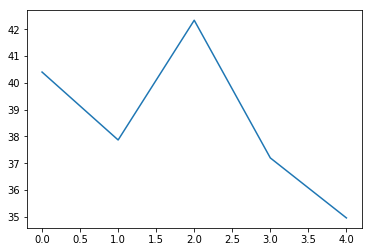

In [70]:
plt.plot(avg_loss)

In [311]:
from torchtext.data import Field
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

#train_iter = multi30k_data.train_batch(n_data=1000)
#for _ in range(100) : next(train_iter)
x, y = next(train_iter)
x = x.to(device)
y = y.to(device)
#inp = inp.squeeze()

target_output   = " ".join([ multi30k_data.trg_lang.vocab.itos[i] for i in y.squeeze() ]) 
tout = translate( encdecrun, x )

output_sentence = " ".join([ multi30k_data.trg_lang.vocab.itos[i] for i in tout ])
print(target_output)
#print(multi30k_data__.trg_lines[i])
print(output_sentence)
print( sentence_bleu( [target_output.split(' ')], output_sentence.split(' ') , smoothing_function=SmoothingFunction().method1) )

torch.Size([1, 12, 12])
torch.Size([1, 12, 12])
torch.Size([1, 12, 12])
torch.Size([1, 12, 12])
torch.Size([1, 12, 12])
torch.Size([1, 12, 12])
torch.Size([1, 12, 12])
torch.Size([1, 12, 12])
<sos> A blond boy in a dark hoodie is holding a fishing rod . <eos>
<sos> A little girl is hugging a train tracks <eos>
0.03403984908815123


In [264]:
vars(encdecrun.encoder.layer_list[-1].multi_head_attn.multi_attn[3])

{'_backend': <torch.nn.backends.thnn.THNNFunctionBackend at 0x7f54547aba90>,
 '_parameters': OrderedDict(),
 '_buffers': OrderedDict(),
 '_backward_hooks': OrderedDict(),
 '_forward_hooks': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_modules': OrderedDict([('wq',
               Linear(in_features=64, out_features=64, bias=True)),
              ('wk', Linear(in_features=64, out_features=64, bias=True)),
              ('wv', Linear(in_features=64, out_features=64, bias=True))]),
 'training': True,
 'attn_scores': tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 

In [64]:
#debug_list = []
def translate( encdecrun, x ) :
    debug_list = [] #XXX
    x = x.to(device)
    
    with torch.no_grad():
        out = encdecrun.run_encoder( x )
    
        #first input is SOS
        next_word = x[0][0].view(1,1,1)
        predicted_target = []
        for i in range(25) :        
            scores = encdecrun.run_decoder( next_word )
            predicted_target.append( next_word.item() )
            if next_word.item() == 3 : #in_data.trg_lang.EOS_token :
                break
            #now we make the next_word from current_word
            v, next_word = scores.topk(1) #return value and index

        
    return predicted_target    
    #return " ".join([ in_data.trg_lang.itos[i] for i in predicted_target ])

In [397]:
from transformer import *

In [526]:
#Debug
from transformer import *

d_model = 16
hidden_size = d_model
#encoder = EncoderRNN(len(multi30k_data.src_lang.vocab), hidden_size).to(device)
n_src_vocab = len(multi30k_data.src_lang.vocab)
n_trg_vocab = len(multi30k_data.trg_lang.vocab)

#encoder = EncoderSimple(n_src_vocab, hidden_size).to(device)
#encoder = EncoderRNN(n_src_vocab, hidden_size).to(device)
encoder = TransformerEncoder(n_src_vocab, d_model=d_model, n_layers=6, n_head=8, n_max_seq=50, d_k=16, d_v=16, d_ffn=16 ).to(device)

decoder = DecoderRNN(hidden_size, n_trg_vocab).to(device)

#decoder = AttnDecoderRNN(hidden_size, len(multi30k_data.trg_lang.vocab), max_length=50  ).to(device)

#print(encoder)
#print(decoder)

learning_rate = 0.01
#encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
encoder_optimizer = optim.Adam( filter(lambda p: p.requires_grad, encoder.parameters()) , lr=learning_rate)

decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss().to(device)
#criterion = nn.CrossEntropyLoss().to(device)

encdecrun = EncodeDecodeRun(encoder,decoder)


avg_loss = []

for _ in range(1) :
    l = train(encdecrun, encoder_optimizer, decoder_optimizer, criterion, multi30k_data.train_batch(n_data=100) )
    m = np.mean(l)
    print("mean iteration loss", m)
    avg_loss.append( m )

12.862537622451782
mean iteration loss 90.81093368530273


In [501]:
encdecrun.out[:,0,:].shape

torch.Size([1, 16])

In [508]:
avg_loss = []

for _ in range(1) :
    l = train(encdecrun, encoder_optimizer, decoder_optimizer, criterion, multi30k_data.train_batch(n_data=10) )
    m = np.mean(l)
    print("mean iteration loss", m)
    avg_loss.append( m )

1.4002470970153809
mean iteration loss 113.62008132934571


In [525]:
vars(encdecrun.encoder.layer_list[-1].multi_head_attn)

{'_backend': <torch.nn.backends.thnn.THNNFunctionBackend at 0x7f54547aba90>,
 '_parameters': OrderedDict(),
 '_buffers': OrderedDict(),
 '_backward_hooks': OrderedDict(),
 '_forward_hooks': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_modules': OrderedDict([('linears', ModuleList(
                 (0): Linear(in_features=16, out_features=16, bias=True)
                 (1): Linear(in_features=16, out_features=16, bias=True)
                 (2): Linear(in_features=16, out_features=16, bias=True)
                 (3): Linear(in_features=16, out_features=16, bias=True)
               ))]),
 'training': True,
 'd_k': 2,
 'h': 8,
 'p': 0.1,
 'attn': tensor([[[[0.0770, 0.0771, 0.0769,  ..., 0.0770, 0.0767, 0.0770],
           [0.0770, 0.0771, 0.0770,  ..., 0.0770, 0.0767, 0.0770],
           [0.0770, 0.0771, 0.0769,  ..., 0.0770, 0.0767, 0.0770],
           ...,
           [0.0770, 0.0771, 0.0769,  ..., 0.0770, 0.0767, 0.0770],
           [0.0770, 0.0771, 0.0769,  ..., 0.0770, 0.

In [527]:
vars(encdecrun.encoder.layer_list[-1].multi_head_attn.multi_attn[1])

{'_backend': <torch.nn.backends.thnn.THNNFunctionBackend at 0x7f54547aba90>,
 '_parameters': OrderedDict(),
 '_buffers': OrderedDict(),
 '_backward_hooks': OrderedDict(),
 '_forward_hooks': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_modules': OrderedDict([('wq',
               Linear(in_features=16, out_features=16, bias=True)),
              ('wk', Linear(in_features=16, out_features=16, bias=True)),
              ('wv', Linear(in_features=16, out_features=16, bias=True))]),
 'training': True,
 'attn_scores': tensor([[[0.0769, 0.0769, 0.0769, 0.0769, 0.0769, 0.0769, 0.0769, 0.0769,
           0.0769, 0.0769, 0.0769, 0.0769, 0.0769],
          [0.0769, 0.0769, 0.0769, 0.0769, 0.0769, 0.0769, 0.0769, 0.0769,
           0.0769, 0.0769, 0.0769, 0.0769, 0.0769],
          [0.0769, 0.0769, 0.0769, 0.0769, 0.0769, 0.0769, 0.0769, 0.0769,
           0.0769, 0.0769, 0.0769, 0.0769, 0.0769],
          [0.0769, 0.0769, 0.0769, 0.0769, 0.0769, 0.0769, 0.0769, 0.0769,
           0.076

In [507]:
vars(encdecrun.encoder.layer_list[5].multi_head_attn.multi_attn[5]._modules['wv'])

{'_backend': <torch.nn.backends.thnn.THNNFunctionBackend at 0x7f54547aba90>,
 '_parameters': OrderedDict([('weight', Parameter containing:
               tensor([[-0.1393,  0.0514,  0.2019,  0.1427,  0.1221, -0.0560,  0.2064, -0.1039,
                         0.2084,  0.1679, -0.2382, -0.1271,  0.0146,  0.2570,  0.0525,  0.2299],
                       [ 0.0951,  0.0387, -0.2208,  0.0574, -0.0978,  0.1056,  0.0005,  0.2208,
                         0.0469,  0.2315, -0.0872,  0.0856, -0.0528, -0.0461, -0.0910,  0.1972],
                       [-0.2368,  0.1206,  0.0623, -0.1754,  0.0178, -0.0068,  0.0193, -0.1841,
                        -0.0849,  0.1108,  0.2137,  0.0750, -0.0302,  0.0954, -0.0778, -0.1217],
                       [ 0.1085,  0.1384,  0.2352, -0.1809,  0.2324, -0.1934, -0.1404,  0.1155,
                         0.0726, -0.2477,  0.1185,  0.1493, -0.0431,  0.0325,  0.0357, -0.0037],
                       [ 0.1079,  0.0658,  0.1791, -0.1359, -0.0310, -0.1219, -0.1528,  0

In [495]:
encdecrun.encoder.layer_list[5].debug_layer_out[0][9:11]

tensor([[ 0.0554, -1.0060,  0.0720,  0.1370,  1.7766,  1.8943, -0.2244, -0.0009,
         -0.7785, -0.9699,  0.5473, -0.4573,  1.7513, -1.3878, -0.2387, -0.2775],
        [ 0.0554, -1.0059,  0.0721,  0.1370,  1.7767,  1.8941, -0.2243, -0.0008,
         -0.7785, -0.9699,  0.5473, -0.4573,  1.7513, -1.3880, -0.2389, -0.2776]],
       device='cuda:0', grad_fn=<SliceBackward>)

In [488]:
encdecrun.encoder.layer_list[0].debug_layer_out.shape

torch.Size([1, 18, 16])

In [442]:
encdecrun.encoder.layer_list[-1].multi_head_attn.debug_heads

[tensor([[[-1.2983, -0.4982, -0.2695, -0.4720,  0.2969,  0.5237, -0.2150,
            0.8114, -0.4790, -0.9530, -0.0177,  0.8000, -0.3304, -0.1785,
            0.3104,  0.7348],
          [-1.2980, -0.4977, -0.2677, -0.4712,  0.2941,  0.5229, -0.2154,
            0.8134, -0.4791, -0.9514, -0.0178,  0.8027, -0.3296, -0.1797,
            0.3095,  0.7353],
          [-1.2985, -0.4983, -0.2691, -0.4721,  0.2964,  0.5237, -0.2154,
            0.8121, -0.4793, -0.9527, -0.0173,  0.8008, -0.3303, -0.1785,
            0.3101,  0.7351],
          [-1.2983, -0.4975, -0.2692, -0.4713,  0.2964,  0.5236, -0.2147,
            0.8119, -0.4789, -0.9524, -0.0175,  0.8007, -0.3306, -0.1792,
            0.3097,  0.7350],
          [-1.2982, -0.4978, -0.2695, -0.4716,  0.2967,  0.5234, -0.2148,
            0.8116, -0.4788, -0.9527, -0.0177,  0.8005, -0.3304, -0.1788,
            0.3102,  0.7348],
          [-1.2984, -0.4984, -0.2697, -0.4721,  0.2972,  0.5237, -0.2151,
            0.8113, -0.4791, -0.9532

In [452]:
encdecrun.encoder.layer_list[-1].multi_head_attn.multi_attn[0].attn_scores

tensor([[[0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111,
          0.1111],
         [0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111,
          0.1111],
         [0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111,
          0.1111],
         [0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111,
          0.1111],
         [0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111,
          0.1111],
         [0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111,
          0.1111],
         [0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111,
          0.1111],
         [0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111,
          0.1111],
         [0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111,
          0.1111]]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [454]:
encdecrun.encoder.layer_list[4].multi_head_attn.debug_multi_head_out

tensor([[[ 3.3234, -4.6378, -8.8014, -7.4195, -2.8737,  4.6062,  2.4097,
          -2.2211,  0.4523,  1.3408,  2.4586, -1.9543,  7.7725,  4.0150,
           0.6621, -0.8382],
         [ 3.3244, -4.6376, -8.7985, -7.4255, -2.8718,  4.6033,  2.4120,
          -2.2204,  0.4471,  1.3409,  2.4589, -1.9540,  7.7702,  4.0194,
           0.6630, -0.8377],
         [ 3.3215, -4.6372, -8.7978, -7.4215, -2.8721,  4.6058,  2.4099,
          -2.2207,  0.4475,  1.3397,  2.4616, -1.9568,  7.7746,  4.0168,
           0.6635, -0.8396],
         [ 3.3220, -4.6363, -8.7970, -7.4227, -2.8713,  4.6076,  2.4108,
          -2.2273,  0.4493,  1.3406,  2.4596, -1.9528,  7.7746,  4.0122,
           0.6634, -0.8379],
         [ 3.3229, -4.6387, -8.7999, -7.4221, -2.8740,  4.6071,  2.4123,
          -2.2219,  0.4534,  1.3410,  2.4572, -1.9539,  7.7701,  4.0139,
           0.6646, -0.8382],
         [ 3.3254, -4.6372, -8.7977, -7.4229, -2.8761,  4.6059,  2.4134,
          -2.2250,  0.4491,  1.3437,  2.4581, -1.951

In [198]:
encoder.layer_list[0].debug_layer_out #.shape

tensor([[[-1.0563, -0.4943, -0.6729,  ...,  1.5320, -1.5187, -0.5448],
         [-1.0568, -0.5071, -0.6675,  ...,  1.5356, -1.5166, -0.5476],
         [-1.0567, -0.5028, -0.6707,  ...,  1.5347, -1.5185, -0.5454],
         ...,
         [-1.0542, -0.4893, -0.6746,  ...,  1.5286, -1.5190, -0.5455],
         [-1.0546, -0.4863, -0.6759,  ...,  1.5253, -1.5188, -0.5462],
         [-1.0555, -0.5064, -0.6718,  ...,  1.5349, -1.5195, -0.5472]]],
       device='cuda:0', grad_fn=<ThAddBackward>)

In [199]:
encoder.layer_list[1].debug_layer_out

tensor([[[-0.4077,  0.1371,  1.0682,  ...,  1.6851,  0.9861,  1.3151],
         [-0.4077,  0.1371,  1.0682,  ...,  1.6851,  0.9861,  1.3151],
         [-0.4077,  0.1371,  1.0682,  ...,  1.6851,  0.9861,  1.3151],
         ...,
         [-0.4077,  0.1371,  1.0682,  ...,  1.6851,  0.9861,  1.3151],
         [-0.4077,  0.1371,  1.0682,  ...,  1.6851,  0.9861,  1.3151],
         [-0.4077,  0.1371,  1.0682,  ...,  1.6851,  0.9861,  1.3151]]],
       device='cuda:0', grad_fn=<ThAddBackward>)

In [208]:
i = encoder.debug4.cpu()

In [373]:
i.shape

torch.Size([1, 1, 3])

In [212]:
a = SingleHeadAttention( d_model, 64,64)

In [213]:
j = a(i,i,i)

In [219]:
i

tensor([[[-0.0531,  1.1602, -0.5094,  ...,  1.3961,  0.3727,  1.3186],
         [-1.2464,  0.4861,  0.2001,  ..., -0.1668, -0.2127,  0.9554],
         [ 0.9070,  0.9194,  0.0652,  ...,  2.3578, -1.3727,  0.8048],
         ...,
         [-0.2455,  1.1601, -0.1252,  ...,  0.7748, -1.5753,  1.6096],
         [-1.5906,  2.1969, -0.5865,  ..., -1.2350,  0.3415,  0.3243],
         [ 0.3325,  2.2613,  0.3707,  ...,  1.2042,  0.8709,  1.6116]]],
       grad_fn=<CopyBackwards>)

In [220]:
scores = torch.matmul( i, i.transpose(-2,-1) ) / np.sqrt( i.shape[-1] )

In [227]:
scores.shape

torch.Size([1, 18, 18])

In [232]:
attn = F.softmax( scores, dim=1 )
attn

tensor([[[9.9824e-01, 7.3582e-04, 4.1573e-03, 1.7024e-03, 1.1599e-04,
          3.9889e-03, 5.5712e-05, 2.1201e-05, 6.4008e-05, 9.1327e-04,
          4.5068e-04, 2.5292e-03, 3.8450e-03, 8.7396e-04, 1.4082e-06,
          2.1406e-04, 2.4357e-06, 3.2947e-05],
         [2.0687e-05, 9.7964e-01, 1.3263e-03, 9.2881e-05, 2.3462e-05,
          1.8193e-03, 1.6197e-05, 2.1462e-07, 4.9257e-04, 5.8975e-04,
          2.0354e-04, 8.9470e-05, 1.7880e-03, 5.4927e-04, 6.1766e-07,
          3.2255e-05, 1.7501e-05, 5.5368e-06],
         [4.9809e-05, 5.6523e-04, 9.4618e-01, 1.0401e-03, 3.3628e-05,
          5.8933e-03, 1.6668e-04, 1.3811e-06, 7.3040e-04, 4.2715e-04,
          1.0194e-03, 4.6980e-04, 3.0871e-04, 7.3678e-04, 4.7323e-07,
          9.4520e-05, 5.8837e-06, 3.5052e-06],
         [2.5439e-05, 4.9366e-05, 1.2972e-03, 9.6780e-01, 6.3556e-06,
          1.2418e-03, 8.4248e-05, 2.2337e-05, 4.6553e-05, 2.6568e-03,
          2.4942e-04, 5.1683e-04, 6.7632e-05, 2.3550e-04, 6.7805e-07,
          3.8570e-0

In [233]:
torch.matmul( attn, i )

tensor([[[-0.0503,  1.1759, -0.5119,  ...,  1.4149,  0.3787,  1.3360],
         [-1.2204,  0.4816,  0.1947,  ..., -0.1552, -0.2071,  0.9410],
         [ 0.8537,  0.8784,  0.0593,  ...,  2.2430, -1.2982,  0.7682],
         ...,
         [-0.2448,  1.1900, -0.1365,  ...,  0.8195, -1.5611,  1.6165],
         [-1.5896,  2.2010, -0.5879,  ..., -1.2269,  0.3436,  0.3295],
         [ 0.3364,  2.2791,  0.3675,  ...,  1.2320,  0.8746,  1.6401]]],
       grad_fn=<UnsafeViewBackward>)

In [42]:
i = torch.randn(1,6)
j = torch.randn(1,6)

In [46]:
torch.cat([torch.randn(1,6) for _ in range(3)], 0).shape

torch.Size([3, 6])

In [414]:
a = SingleHeadAttention( 6, 10,10)

In [415]:
k = a(i,j,j)

In [416]:
k.shape

torch.Size([1, 2, 10])

In [417]:
a.attn_scores.shape

torch.Size([1, 2, 5])

In [418]:
a.attn_scores

tensor([[[0.1772, 0.2811, 0.1504, 0.2273, 0.1640],
         [0.3290, 0.2425, 0.1763, 0.1209, 0.1313]]],
       grad_fn=<SoftmaxBackward>)

In [419]:
l = torch.cat( [k, k], dim=-1 )

In [41]:
l.shape

AttributeError: 'float' object has no attribute 'shape'

In [40]:
l

0.0

In [39]:
k

0.0

In [366]:
k = torch.matmul(j, i)
k

RuntimeError: invalid argument 2: wrong matrix size, batch1: 1x3, batch2: 1x3 at /opt/conda/conda-bld/pytorch_1532579245307/work/aten/src/TH/generic/THTensorMath.cpp:2312

In [38]:
torch.sum(j[0][0] * i[0,:,1])

TypeError: 'float' object is not subscriptable